**VIS + NIR tutorial**

For dual VIS/NIR workflows, a visible image is used to identify an image mask for the plant material. We use a landmark transformation to place the VIS image mask over the NIR image. This allows two workflows to be done at once and also allows plant material to be identified in low-quality images. We do not recommend this approach if there is a lot of plant movement between capture of NIR and VIS images.

Updated July 2025.

In [ ]:
# Install PlantCV and required dependencies
%pip install "altair>=5" ipympl plantcv

# Give access and mount your Google Drive (need a Google Account)
# Change path to directory you wish output files to be saved to.
from google.colab import drive
drive.mount('/content/gdrive')

# Enable widget feature with matplotlib
from google.colab import output
output.enable_custom_widget_manager()

#View working directory, may need to change path
%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive'

In [ ]:
# Change your working directory to the mounted drive
%cd gdrive/MyDrive/
# Print the contents of your drive to confirm it worked
!ls
# Clone the workshop's repository to your Google Drive
!git clone https://github.com/danforthcenter/plantcv-tutorial-vis-nir.git

[Errno 2] No such file or directory: 'gdrive/MyDrive/'
/content/gdrive/MyDrive
 90finalplotsEX10.csv
 90finalplotsEX10.gsheet
 90finalplotsEX6.csv
 90finalplotsEX6.gsheet
 90finalplotsEX7.csv
 90finalplotsEX7.gsheet
 90finalplotsEX8.csv
 90finalplotsEX8.gsheet
 90finalplotsEX9.csv
 90finalplotsEX9.gsheet
 bg1b108_plate2_2025_02_21.jpeg
 bg1b108_plate2_2025_02_21.jpg
 bg1b73_plate2_2025_02_21.jpg
 bg1B84_plate2_2025-02-04.jpg
 bg1B97_plate2_2025-02-04.jpg
 bg1cml103_plate2_2025_02_21.jpg
 bg1cml228_plate2_2025_02_21.jpg
 bg1CML247_plate2_2025-02-04.jpg
 bg1cml277_plate2_2025_02_21.jpg
 bg1cml322_plate2_2025_02_21.jpg
 bg1CmL333_plate2_2025-02-04.jpg
 bg1cml52_plate2_2025_02_21.jpg
 bg1cr1ht_plate2_2025_02_21.jpg
 bg1hp301_plate2_2025_02_21.jpg
 bg1IL14H_plate2_2025-02-04.jpg
 bg1Ki11_plate2_2025-02-04.jpg
 bg1ki3_plate2_2025_02_21.jpg
 bg1ky21_plate2_2025_02_2021.jpg
 bg1lh145_plate2_2025_02_21.jpg
 bg1LH149_plate2_2025-02-04.jpg
 bg1LH197_plate2_2025-02-04.jpg
 bg1m162w_plate2_2025_02_

In [ ]:
# Import the needed packages needed to run

%matplotlib inline
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs


In [ ]:
# Import a sample image and define it to be used in the notebook
# for parallelization with multiple images see documentation of groupby and group_name
# fields of the configuration json.
args = WorkflowInputs(
    images=["./plantcv-tutorial-vis-nir/sample_images/VIS_SV_0_z1_h1_g0_e77_v500_84572_0.png",
            "./plantcv-tutorial-vis-nir/sample_images/NIR_SV_0_z1_h1_g0_e21500_v500_84575_0.png"],
    names="vis,nir",
    result="data_output.json",
    outdir="img_output",
    writeimg=False,
    debug="plot"
)


In [ ]:
# Set debug to the global parameter
pcv.params.debug = args.debug

# Change the display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.debug_outdir = args.outdir

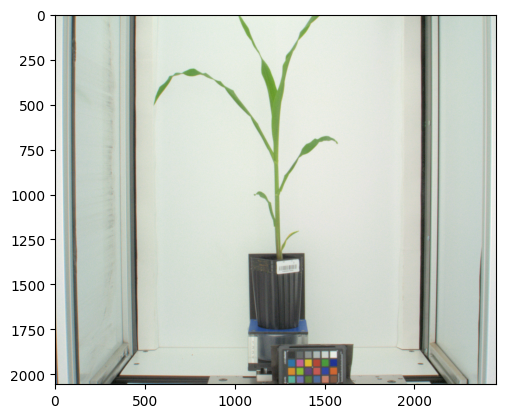

In [ ]:
# Read VIS image

# Filename - Image file to be read in
img, path, filename = pcv.readimage(filename=args.vis)

In [ ]:
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')
thresh = pcv.threshold.binary(gray_img=b, threshold=145, object_type='light')

alt.FacetChart(...)

In [ ]:
filled_mask = pcv.fill(bin_img=thresh, size=1000)

In [ ]:
roi = pcv.roi.rectangle(img=img, x=1000, y=700, h=650, w=500)

In [ ]:
# Filter binary image to make a clean mask
mask = pcv.roi.quick_filter(mask=filled_mask, roi=roi)

In [ ]:
############### VIS (RGB) Analysis ################ 
analysis_image = pcv.analyze.size(img=img, labeled_mask=mask, label="default")
color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=mask, label="default")

In [ ]:
# Read in NIR image
nir, path1, filename1 = pcv.readimage(filename=args.nir, mode='native')

In [ ]:
# Apply landmark transformation (we chose to use the screws in the background) to align both images 
img_warped, mat = pcv.transform.warp(img=mask, refimg=nir,
                                     pts = [(500, 454), (1995, 454), (1995, 1136), (1984, 1811), (511, 1804), 
                                            (500, 1136)],
                                     refpts = [(100, 130), (527, 120), (526, 314), (526, 504), (100, 516), 
                                               (100, 322)],
                                     method='lmeds')

In [ ]:
# Analyze NIR pixel intensity values of the plant
# changing the label here would separate results in the JSON output but complicate any CSV downstream
nir_hist = pcv.analyze.grayscale(gray_img=nir, labeled_mask=img_warped, bins=100, label="default")

In [ ]:
# Make a histogram visualization 
nir_hist = pcv.visualize.histogram(img=nir, mask=img_warped, lower_bound=0, upper_bound=None, bins=50,
                                   title="Histogram of NIR signal intensity")

In [ ]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis.
pcv.outputs.save_results(filename=args.result, outformat="json")